In [2]:
import pandas as pd
import math
import os
import numpy as np
from prophet import Prophet
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px 
import random
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm

# FUNCTIONS

In [29]:
def adjust_df(df):
    '''Applies changes on data imported from yahoo finance'''
    for col in df.columns:
        df.rename(columns={col:col.lower()}, inplace=True)
    df.drop(["volume"], axis=1, inplace=True)
    df.reset_index(inplace=True)
    
    return df

In [30]:
def store(df, name="MA_tests.csv"):
    '''Concats the data from a csv and the data from dataframe, then saves it to the csv'''
    name = os.path.join("../csvs", name) 
    if os.path.exists(name):
        read = pd.read_csv(name)
        df = pd.concat([df, read])
        df = df.drop_duplicates(subset=['symbol', 'period', 'interval', 'MA_1', 'MA_2'])
    
    df = df[df.result != 0].reset_index(drop=True)
    df[[col for col in df.columns if col != "index"]].to_csv(name, index=False)
    
    return df

In [5]:
def analyze(symbol, period, interval, means):
    '''Calculates the gain in pips achieved with the MA strategy'''
    
    df = yf.download(symbol, period=period, interval=interval);
    adjust_df(df)
    
    target = df['close']
    
    
    ma_cols = []
    for i, mean in enumerate(means):
        name = "MA_"+str(mean)
        df[name] = target.rolling(window=mean).mean()
        df[name] = df[name].shift(periods=i)
        ma_cols.append(name)
    
    
    df['diff'] = df[ma_cols[0]] - df[ma_cols[1]]
    df['diff'] = df['diff'].astype(float)
    df['diff_prev'] = df['diff'].shift(1)

    df.dropna(how='any', inplace=True);
    df.reset_index(drop=True, inplace=True)
    
    def is_trade(row):
        if row['diff'] >= 0 and row['diff_prev'] < 0:
            return 1
        if row['diff'] <= 0 and row['diff_prev'] > 0:
            return -1

        return 0 
    
    df['is_trade'] = df.apply(is_trade, axis=1)
    
    
    df_trades = df[df.is_trade != 0].copy().reset_index()

    
    
    df_trades['delta'] = (df_trades.close.diff() / 0.0001).shift(-1)
    df_trades['gain'] = df_trades['delta'] * df_trades['is_trade'] + 10 * df_trades['is_trade']
    
    result = df_trades['gain'].sum() #* 0.0001
    
    row = pd.DataFrame({
        'symbol': symbol,
        'period': period,
        'interval': interval,
        'MA_1': means[0],
        'MA_2': means[1],
        'result': result
    }, index=[0])
    return row 

# SETUP

In [6]:
df = pd.DataFrame(columns=['symbol', 'period', 'interval', 'MA_1', 'MA_2', 'result']).reset_index(drop=True)

In [7]:
df = store(df)

In [8]:
# symbols = ["EURUSD=X", "GBPUSD=X", "AUDUSD=X"]
symbols = [ "EURUSD=X" ]
periods = ["1d", "1h", "14d", "1mo", "1y", "2y" ]
intervals = ["1m", "5m", "15m", "1h", "1d"]
MA_1s =  list(range(10, 130, 10))
MA_2s =  list(range(10, 130, 10))
# symbols = ["EURUSD=X"]
# periods = ["1y"]
# intervals = ["1d"]
# MA_1s =  [40]
# MA_2s =  [50]

In [9]:
with tqdm(total=(len(symbols)*len(periods)*len(intervals)*len(MA_1s)*len(MA_2s))) as pbar:
    for symbol in symbols:
        for period in periods:
            for interval in intervals:
                for MA_1 in MA_1s:
                    for MA_2 in MA_2s:
                        pbar.update(1)
                        # if len(df[(df['symbol'] == symbol) & (df['period'] == period) & (df['interval'] == interval) & (df['MA_1'] == MA_1) & (df['MA_2'] == MA_2)]) & MA_1 > MA_2:
                        if MA_1 > MA_2:
                            continue

                        original_stdout = sys.stdout
                        sys.stdout = open('/dev/null', 'w')

                        new = analyze(symbol, period, interval, [MA_1,MA_2]);
                        df = pd.concat([new,df.loc[:]]).reset_index(drop=True);

                        sys.stdout = original_stdout 


  0%|          | 0/4320 [00:00<?, ?it/s]

In [31]:
df = store(df, name="MA_tests.csv")
df[df['symbol'] == "EURUSD=x"].sort_values(by='result', ascending=False)

,symbol,period,interval,MA_1,MA_2,result


In [11]:
len(df)

1243

In [12]:
df['result'].sum()

460826188.627491

# EXPLORATION

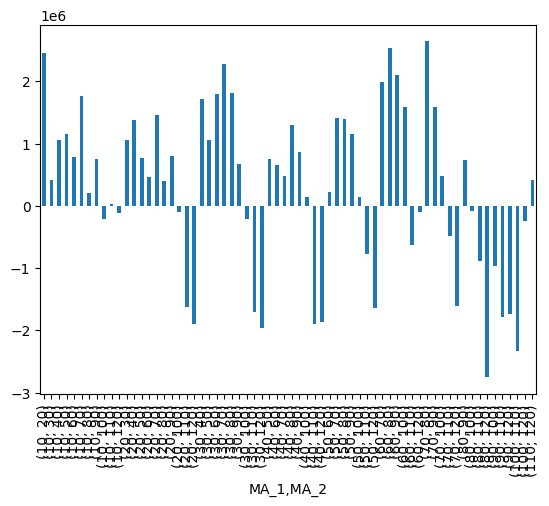

In [13]:
df2 = df.groupby(["MA_1", "MA_2"])['result'].mean()

ax = df2.plot(x='MA_2', y='result', kind='bar')

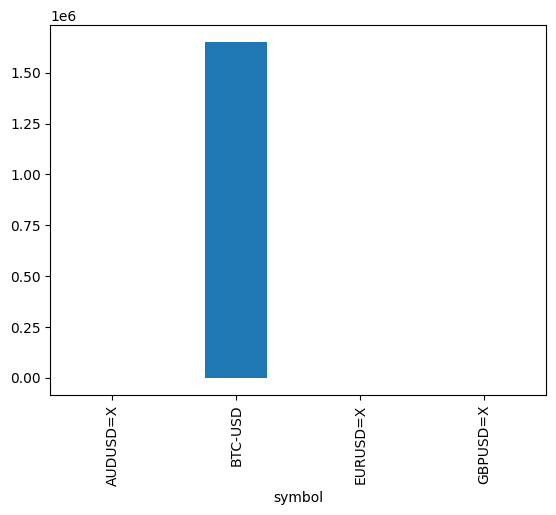

In [14]:
df2 = df.groupby(["symbol"])['result'].mean()

ax = df2.plot(x='symbol', y='result', kind='bar')